# TP53 Methods - Figures
## Code to generate figures for the manuscript and abstracts

### Standard imports, including CPTAC package

In [1]:
import pandas as pd
import numpy as np
import re
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import CPTAC.Endometrial as CPTAC

Welcome to the CPTAC data service package. Available datasets may be
viewed using CPTAC.list(). In order to access a specific data set,
import a CPTAC subfolder using either 'import CPTAC.Dataset' or 'from
CPTAC import Dataset'.
******
Version: 0.2.5
******
Loading Endometrial CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Acetylation Proteomics Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter embargo() to open the webpage for more details.


### Set up initial dataframes and variables

In [2]:
import CPTAC.Endometrial as CPTAC

In [3]:
somatic = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

In [10]:
gene = 'PIK3CA'

# A list of mutations present in the hotspot according to our Hotspot3D output
hotspot_mutations = ['p.E545A', 'p.E545K', 'p.E545V', 'p.Q546P', 'p.Q546R', 'p.E542K']
mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations)) & (somatic['Gene'] == gene)]

# Get a list of patient identifiers for those who have mutations in the hotspot
hotspot_patients_both_keys = mutated_hotspot[['Clinical_Patient_Key', 'Patient_Id']]
hotspot_patients = hotspot_patients_both_keys['Clinical_Patient_Key']
hotspot_patients

160      S001
1147     S003
1357     S009
4630     S021
16486    S023
19061    S024
21259    S032
21516    S033
22497    S038
37421    S061
38155    S063
39522    S066
43391    S067
43490    S068
46662    S084
47360    S088
47857    S090
49362    S097
49475    S098
Name: Clinical_Patient_Key, dtype: object

## Recomb-CCB Poster Figure

In [50]:
protein = 'PTEN'
protdf = CPTAC.compare_mutations(proteomics, protein, gene)
protdf['Within_Hotspot'] = 'Outside_Hotspot'
protdf.loc[hotspot_patients, 'Within_Hotspot'] = 'Within_Hotspot'
protdf.loc[protdf['Mutation'] == 'Wildtype_Tumor', 'Within_Hotspot'] = 'Wildtype'
protdf = protdf.loc[protdf['Sample_Status'] == 'Tumor'].dropna(axis=0)

mut = protdf.loc[protdf['Within_Hotspot'] == 'Within_Hotspot']
wt = protdf.loc[protdf['Within_Hotspot'] == 'Wildtype']
print(scipy.stats.ttest_ind(mut[protein], wt[protein]))

Ttest_indResult(statistic=-2.358259075784955, pvalue=0.021379145894699855)


In [54]:
site = 'PIK3CA-T313'
sitedf = CPTAC.compare_mutations(phos, site, gene)
sitedf['Within_Hotspot'] = 'Outside_Hotspot'
sitedf.loc[hotspot_patients, 'Within_Hotspot'] = 'Within_Hotspot'
sitedf.loc[sitedf['Mutation'] == 'Wildtype_Tumor', 'Within_Hotspot'] = 'Wildtype'
sitedf = sitedf.loc[sitedf['Sample_Status'] == 'Tumor'].dropna(axis=0)
mut = sitedf.loc[sitedf['Within_Hotspot'] == 'Within_Hotspot']
wt = sitedf.loc[sitedf['Within_Hotspot'] == 'Wildtype']
print(scipy.stats.ttest_ind(mut[site], wt[site]))

Ttest_indResult(statistic=-1.9108249470176488, pvalue=0.06448893959367591)


95


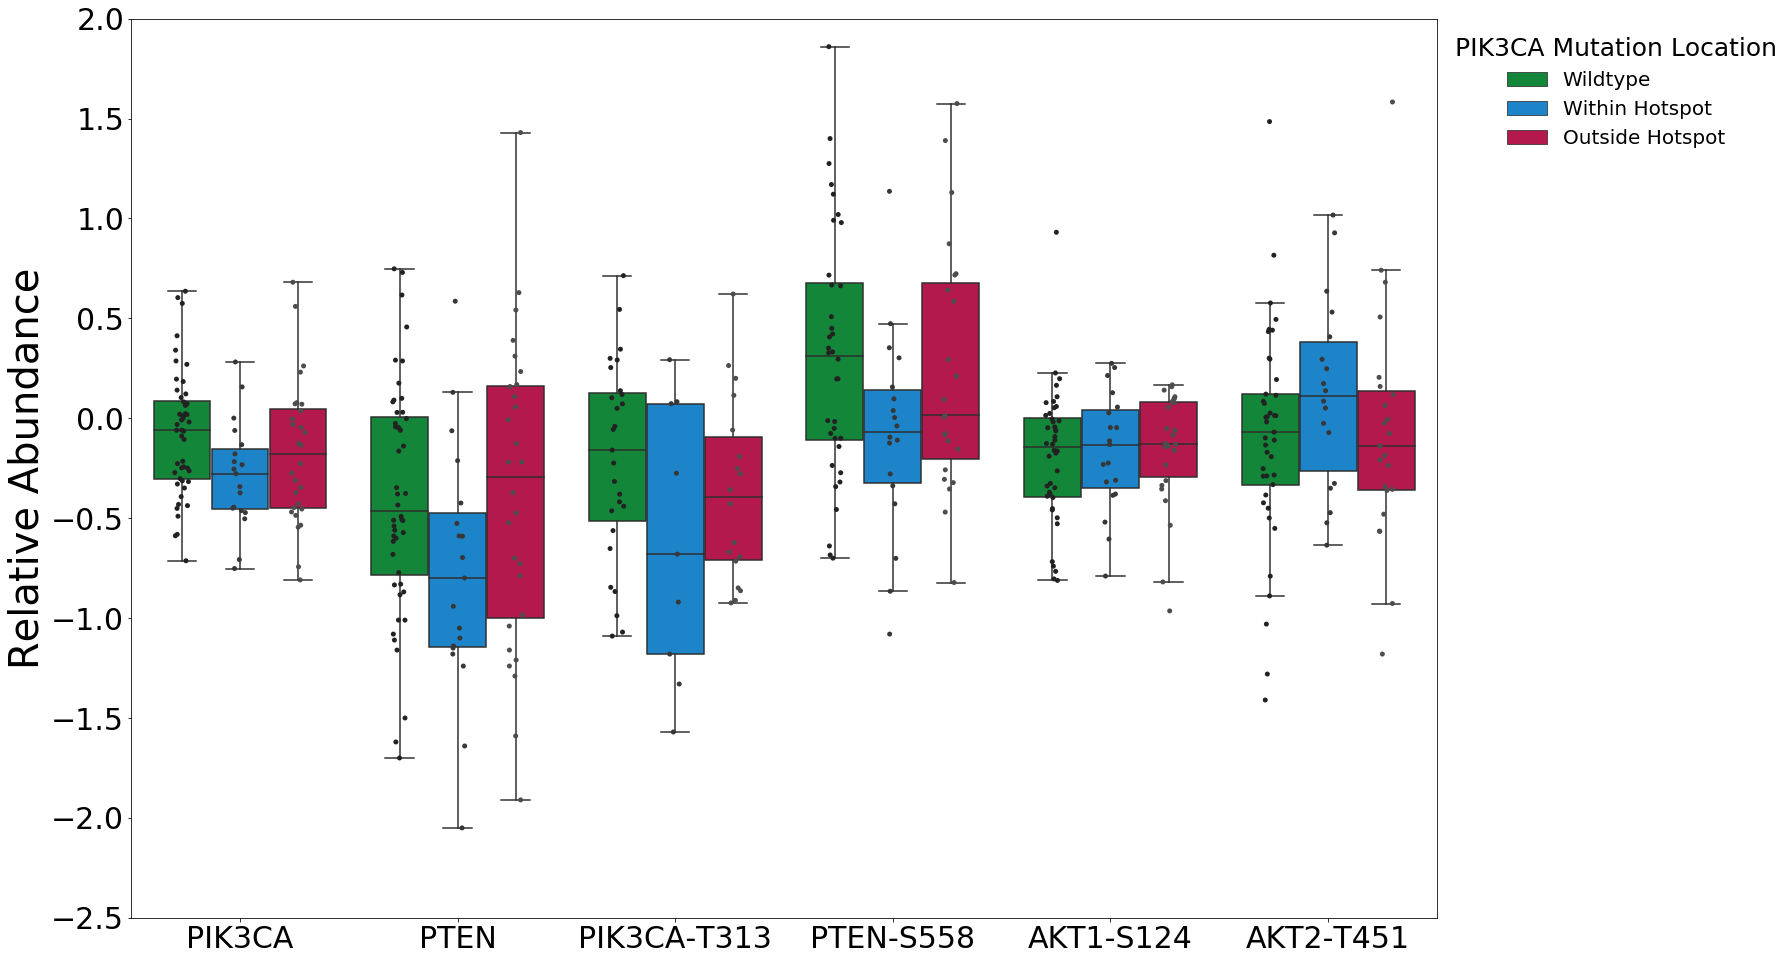

In [55]:
phosphositeList = ['PIK3CA-T313', 'PTEN-S558', 'AKT1-S124', 'AKT2-T451']
protList = ['PTEN']
plotdf = CPTAC.compare_mutations(proteomics, gene)
plotdf = plotdf.loc[plotdf['Sample_Status'] == 'Tumor'][[gene, 'Mutation']]

for protein in protList:
    proteindf = CPTAC.compare_mutations(proteomics, protein, gene)[[protein]]
    plotdf = plotdf.join(proteindf)
    
for site in phosphositeList:
    sitedf = CPTAC.compare_mutations(phos, site, gene)[[site]]
    plotdf = plotdf.join(sitedf)
    
plotdf['Within_Hotspot'] = 'Outside Hotspot'
plotdf.loc[hotspot_patients, 'Within_Hotspot'] = 'Within Hotspot'
plotdf.loc[plotdf['Mutation'] == 'Wildtype_Tumor', 'Within_Hotspot'] = 'Wildtype'
plotdf = pd.melt(plotdf, id_vars = ['Mutation', 'Within_Hotspot'], var_name = 'Protein', value_name = 'Proteomics')
plotdf = plotdf.dropna(axis = 0)

a4_dims = (23.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)

#Create the plot
boxplt = sns.boxplot(x='Protein', y='Proteomics', hue='Within_Hotspot', hue_order = ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], data=plotdf, palette=my_pal, showfliers = False)
boxplt = sns.stripplot(data=plotdf, x='Protein', y='Proteomics', hue='Within_Hotspot', hue_order = ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Relative Abundance', fontsize='40')
boxplt.tick_params(labelsize='30')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:3], ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], title='PIK3CA Mutation Location', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('25')
boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))
plt.ylim(-2.5, 2)
fig = boxplt.get_figure()
fig.savefig('hotspot_proteins.png', dpi=300)
plt.show()

## PIK3CA Figure

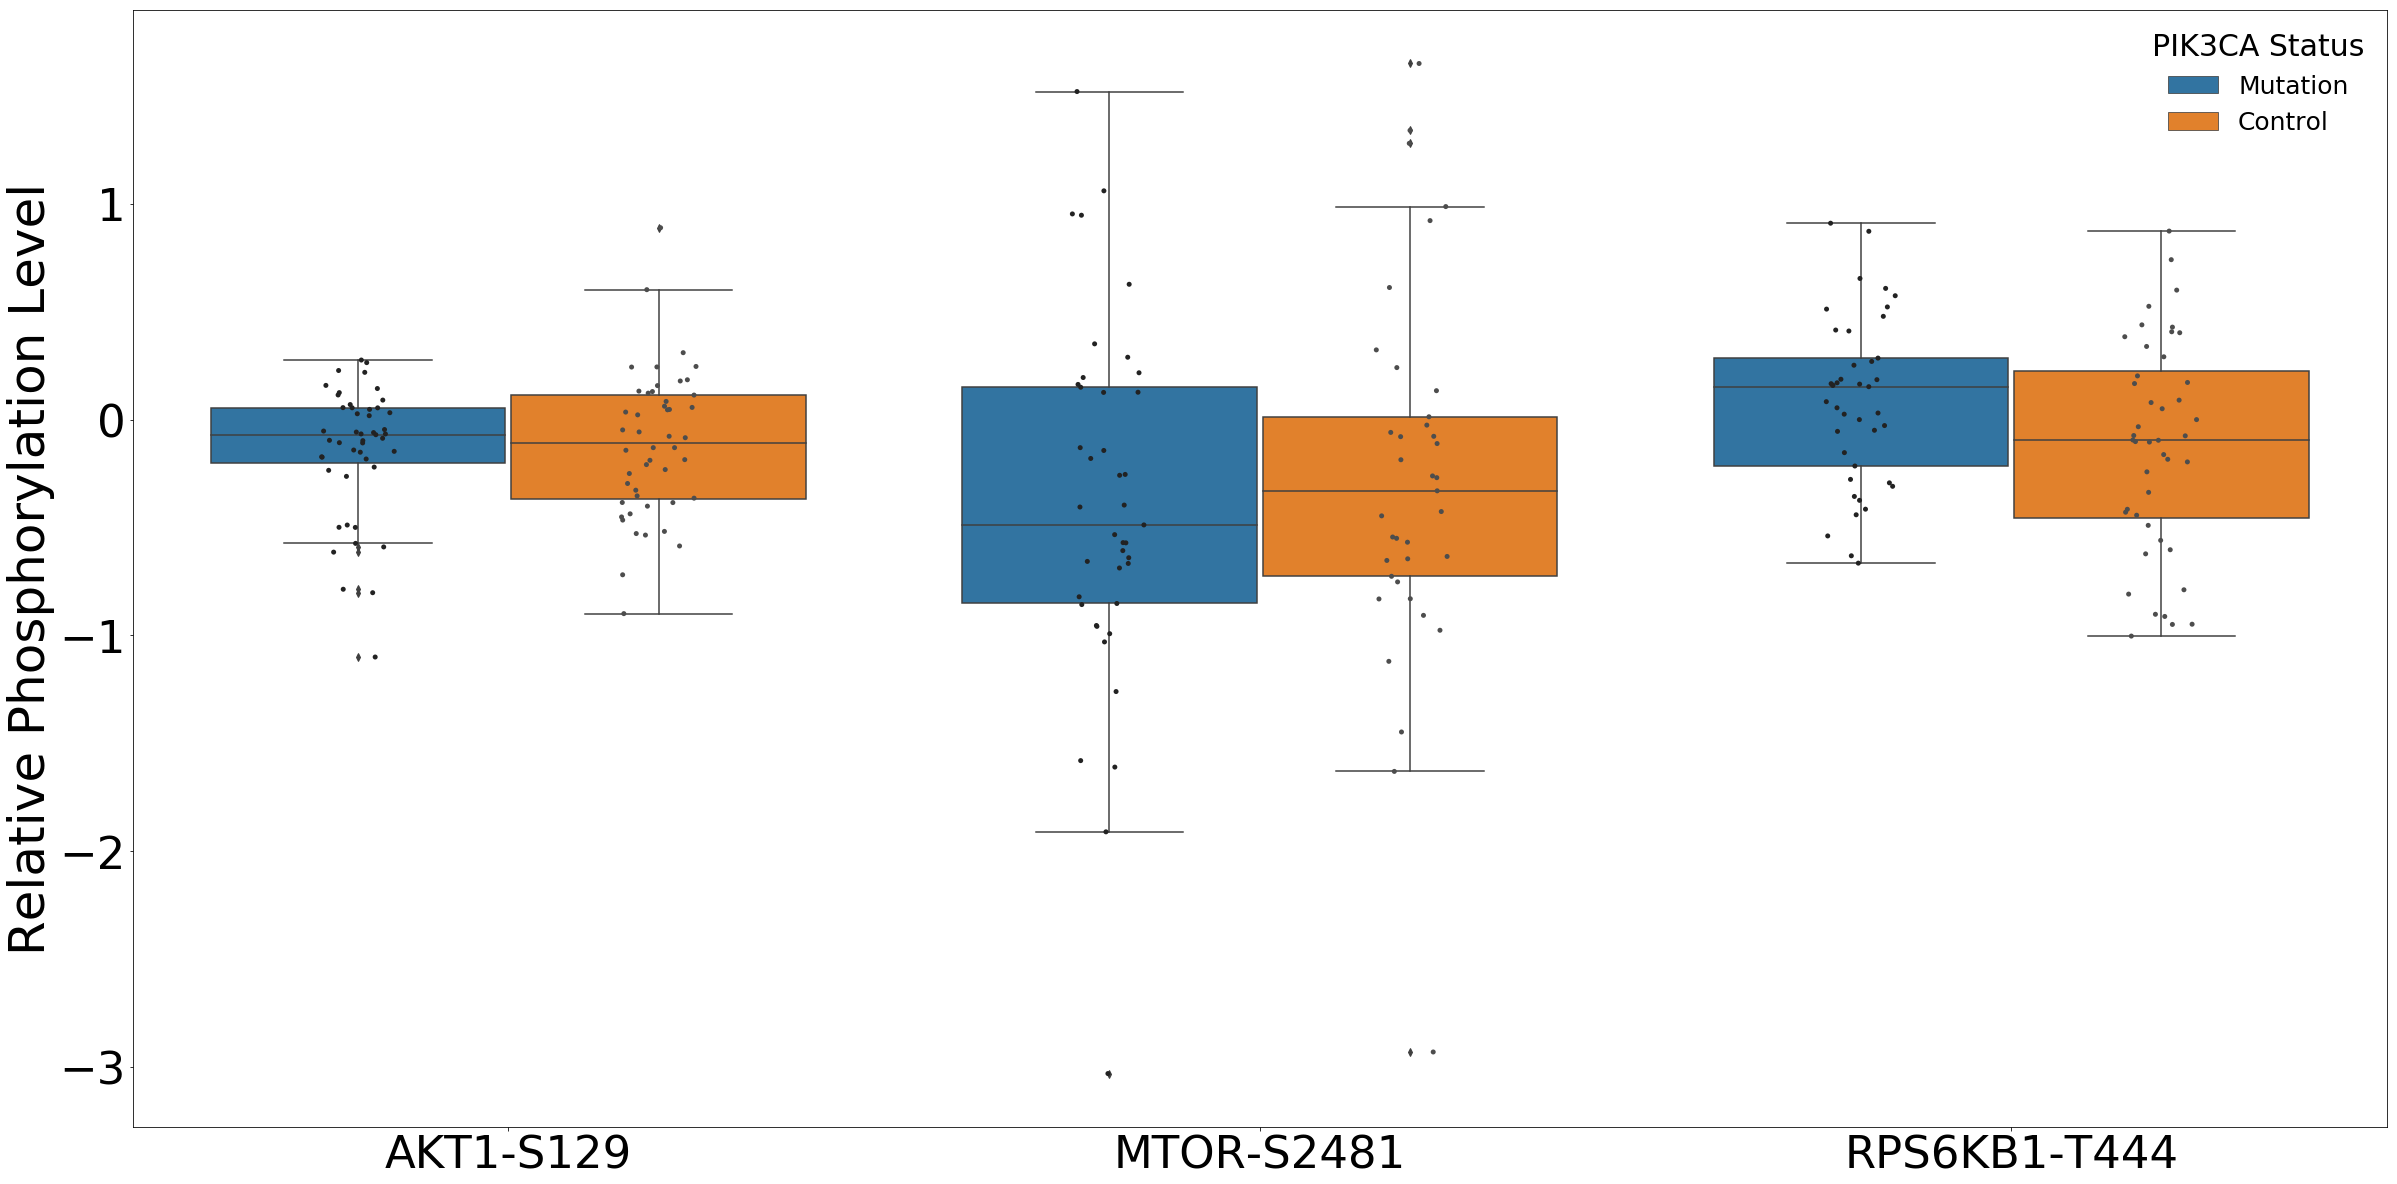

In [12]:
gene = 'PIK3CA'
plotdf = CPTAC.compare_mutations(proteomics, gene)
plotdf = plotdf.loc[plotdf['Sample_Status'] == 'Tumor'][['Mutation', gene]]
#print(plotdf)

sigResults = ['AKT1-S129', 'MTOR-S2481', 'RPS6KB1-T444' ]

#sigResults = sigResults[:5]
#print(sigResults)
for protein in sigResults:
    if(protein != 'ARID1A'):
        phosdf = CPTAC.compare_mutations(phos, protein, gene)[[protein]]
        plotdf = plotdf.join(phosdf)
plotdf = plotdf.drop(gene, axis = 1)
plotdf = plotdf.replace({'Mutation': {'Frame_Shift_Del': 'Mutation',
                                      'Frame_Shift_Ins': 'Mutation',
                                      'In_Frame_Del': 'Mutation',
                                      'Nonsense_Mutation': 'Mutation',
                                      'Wildtype': 'Control',
                                      'Missense_Mutation': 'Mutation'
                                     }})
plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Protein', value_name='Protein Level')
plotdf = plotdf.dropna(axis=0)

a4_dims = (40.4, 20.54)
fig, ax = plt.subplots(figsize=a4_dims)

#Create the plot
boxplt = sns.boxplot(x='Protein', y='Protein Level', hue='Mutation', data=plotdf)
boxplt = sns.stripplot(data=plotdf, x='Protein', y='Protein Level', hue='Mutation', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Relative Phosphorylation Level', fontsize='50')
boxplt.tick_params(labelsize='45')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Mutation', 'Control'], title='PIK3CA Status', fontsize='25', frameon=False)
boxplt.get_legend().get_title().set_fontsize('30')
boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))


fig = boxplt.get_figure()
fig.savefig('pik3ca.png', dpi=300)
plt.show()